# Class Session 4 Exercise:
## Comparing asymptotic running time for enumerating neighbors of all vertices in a graph

We will measure the running time for enumerating the neighbor vertices for three different data structures for representing the graph:
    adjacency matrix
    adjacency list
    edge list
    
First, we import all the R packages that we will need for this exercise:

In [1]:
library(igraph)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




Define a function that enumerates the neighbors of a vertex i, when the 
graph is stored in adjacency matrix format (ones and zeroes).  Use the `which` function.

In [2]:
enumerate_matrix <- function(gmat, i) {
    which(gmat[i, ] == 1)
}

Define a function that enumerates the neighbors of a vertex i, when the 
graph is stored in adjacency list format. Use the `[[` function (i..e, array indexing).

In [3]:
enumerate_adj_list <- function(adj_list, i) {
    adj_list[[i]]
}

Define a function that enumerates the neighbors of a vertex i, when the 
graph is stored in edge-list format.  Use the `which` function and then the `c` (concatenate) function.

In [4]:
enumerate_edge_list <- function(edge_list, i) {
    inds1 <- which(edge_list[,1] == i)
    inds2 <- which(edge_list[,2] == i)
    c(edge_list[inds1,2], edge_list[inds2,1])
}

This next function is the simulation funtion.  "n" is the number of vertices.
It returns a length-three list containing the average running time for enumerating the neighbor vertices of a vertex in the graph. 

Use the `sample_pa` function in igraph to generate a Barabasi-Albert (undirected) graph, with n vertices and m=5 (which should have number of edges equal to nm - m^2 / 2 - m/2).
It returns a length-three list containing the average running time for enumerating the neighbor vertices of a vertex in the graph. 

In [5]:
dosim <- function(n) {

    nrep <- 10
    nsubrep <- 10
    
    simdf <- do.call(rbind,
                     replicate(nrep, {
                        # make a random undirected graph with fixed (average) vertex degree = 5
                         g <- sample_pa(n, out.seq=rep(5, n), directed=FALSE)
                         
                         g_matrix <- as.matrix(as_adjacency_matrix(g))
                         g_adj_list <- as_adj_list(g)
                         g_edge_list <- as_edgelist(g)

                         time_mat <- system.time(
                             replicate(nsubrep, {
                                 lapply(1:n,
                                        function(i) {
                                            enumerate_matrix(g_matrix, i)
                                        })
                             })
                         )[1]
                         
                         time_adj_list <- system.time(
                             replicate(nsubrep, {
                                 lapply(1:n,
                                        function(i) {
                                            enumerate_adj_list(g_adj_list, i)
                                        })
                             })
                         )[1]
                         
                         time_edge_list <- system.time(
                             replicate(nsubrep, {
                                 lapply(1:n,
                                        function(i) {
                                            enumerate_edge_list(g_edge_list, i)
                                        })
                             })
                         )[1]

                         rowdf <- data.frame(matrix=time_mat,
                                             adjlist=time_adj_list,
                                             edgelist=time_edge_list)
                         
                         rowdf
                     }, simplify=FALSE)
                     )
    
    # average over replicates
    simres <- apply(simdf, 2, mean)
    
    # divide by n so that the running time results are on a per-vertex basis
    simres/n
}


Run the function for the graphs of 100, 300, and 500 vertices, and gather the results in a list:

In [16]:
nvals <- c(100, 300, 500)
sim_data_list <- lapply(nvals, dosim)

Rescale the list to make the numbers in milliseconds:

In [17]:
sim_data_list_rescaled <- lapply(sim_data_list, function(v) {v*1000})

Let's have a look at the data in the list format:

In [18]:
sim_data_list_rescaled

[[1]]
  matrix  adjlist edgelist 
   0.053    0.013    0.147 

[[2]]
    matrix    adjlist   edgelist 
0.06533333 0.01566667 0.28266667 

[[3]]
  matrix  adjlist edgelist 
  0.0876   0.0154   0.4514

Convert the list to a wide data frame, using do.call and rbind; make the network size the first column of the data frame (and as a factor)

In [19]:
sim_data_list_df <- data.frame(network_size=as.factor(nvals),
                               do.call(rbind, sim_data_list_rescaled))

Let's have a look at the wide data frame format:

In [20]:
sim_data_list_df

network_size,matrix,adjlist,edgelist
<fct>,<dbl>,<dbl>,<dbl>
100,0.05300000,0.01300000,0.1470000
300,0.06533333,0.01566667,0.2826667
500,0.08760000,0.01540000,0.4514000


"Melt" the data into a narrow format:

In [21]:
library(dplyr)
library(reshape2)
sim_data_list_melted <- melt(sim_data_list_df, id.vars="network_size")

Let's have a look at the narrow data frame format:

In [22]:
sim_data_list_melted

network_size,variable,value
<fct>,<fct>,<dbl>
100,matrix,0.05300000
300,matrix,0.06533333
500,matrix,0.08760000
100,adjlist,0.01300000
300,adjlist,0.01566667
500,adjlist,0.01540000
100,edgelist,0.14700000
300,edgelist,0.28266667
500,edgelist,0.45140000


Let's plot the data.  The "barchart" function in lattice graphics is a nice way to plot a grouped bar plot from a narrow data frame. 

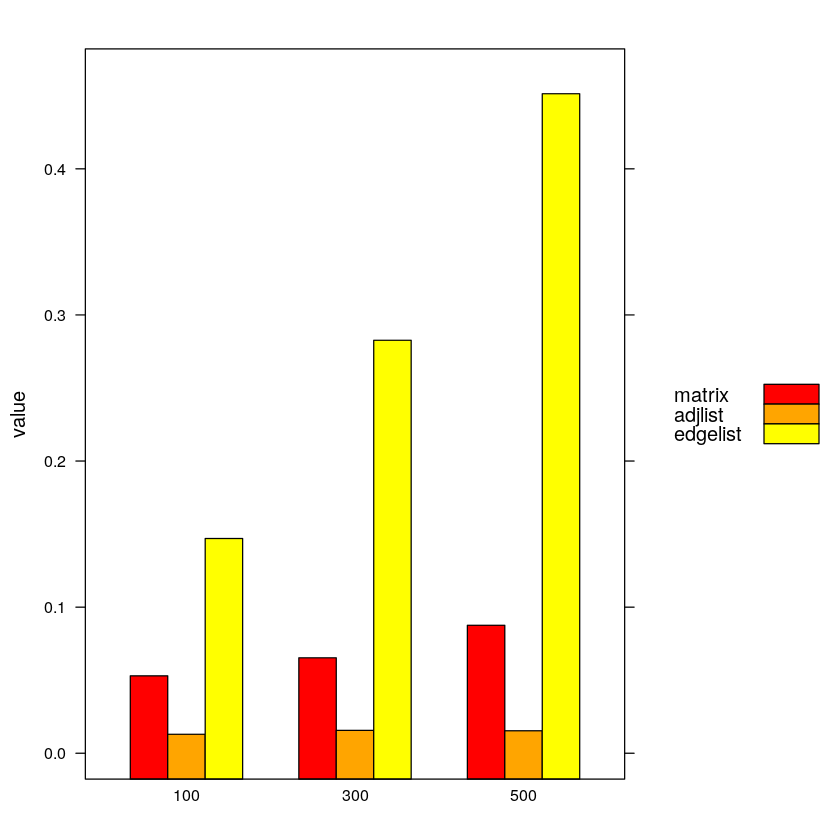

In [23]:
library(lattice)
colors = c('red', 'orange', 'yellow')
barchart(value~network_size, data=sim_data_list_melted, groups=variable,
         auto.key=list(space='right'),
        par.settings=list(superpose.polygon=list(col=colors)))